# Dataproc Workflow jobs analysis

* This code will not run incrementally, but historically
* Tables will be recreated at each run

### 1. Install upgrade dependencies

In [17]:
pip install google-cloud-dataproc

Note: you may need to restart the kernel to use updated packages.


In [211]:
pip install --upgrade google-api-core

Note: you may need to restart the kernel to use updated packages.


##### 1.1 RESTART KERNEL

### 2. Variables and imports

In [3]:
from google.cloud import dataproc_v1 as dataproc
from google.api_core import client_options
from google.longrunning.operations_pb2 import ListOperationsRequest
from typing import Sequence, Tuple, Union
from google.protobuf.json_format import MessageToJson 
import json
import pandas as pd
from google.cloud import bigquery

In [18]:
PROJECT_ID = "YOUR_OWN_PROJECT_ID"
GCP_REGION = "us-central1"
BQ_DATASET_NAME = "dataproc_analysis"
BQ_TABLE_NAME_RAW = "operations_raw"
BQ_TABLE_NAME_CLEAN = "operations_clean"
BQ_TABLE_NAME_MODEL = "operations_model"

In [5]:
client_options = client_options.ClientOptions(
    api_endpoint=f"{GCP_REGION}-dataproc.googleapis.com:443"
)
workflow_template_client = dataproc.WorkflowTemplateServiceClient(client_options=client_options)
bq_client = bigquery.Client()

In [6]:
def run_bq_query(sql_query):
    query_job = bq_client.query(sql_query)
    return query_job.result()

In [7]:
def save_to_bq(table_id, df, schema = None):
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_APPEND",
        schema = schema
    )

    job = bq_client.load_table_from_dataframe(df, table_id, job_config=job_config) 
    return job.result()

In [29]:
SQL_QUERY = f"""
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
    (
        clusterUuid STRING,
        clusterName STRING,
        operationType STRING,
        status STRING,
        statusHistory STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
    (
        clusterUuid STRING, 
        clusterName STRING,
        operationType STRING,
        stateStartTime STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    (
        clusterUuid STRING, 
        clusterName STRING,
        created TIMESTAMP,
        deleted TIMESTAMP,
        seconds_elapsed INTEGER,
        date DATE,
        hour INTEGER
    );
"""
run_bq_query(SQL_QUERY)

### 3. List workflow templates

In [10]:
parent = f"projects/{PROJECT_ID}/regions/{GCP_REGION}"
request = dataproc.ListWorkflowTemplatesRequest(parent=parent)

In [11]:
page_result = workflow_template_client.list_workflow_templates(request=request)

In [13]:
workflow_templates = []

for response in page_result:
    workflow_templates.append({
        "name": response.name,
        "id": response.id
    })
    
workflow_templates

[{'name': 'projects/lgbaeza-202310/regions/us-central1/workflowTemplates/template-27b5c',
  'id': 'template-27b5c'}]

### 4. Get cluster operations and save them into BigQuery

In [21]:
parent = f"projects/{PROJECT_ID}/regions/{GCP_REGION}/operations"
request = ListOperationsRequest(
    name=parent
)

In [22]:
operations = []

nextPageToken = "start"
while nextPageToken != "":
    execution_request = workflow_template_client.list_operations(request=request)
    for ops in execution_request.operations:
        if ops.metadata.type_url == "type.googleapis.com/google.cloud.dataproc.v1.ClusterOperationMetadata":
            cluster_metadata = json.loads(MessageToJson(ops.metadata))
            operations.append(cluster_metadata)

    df = pd.DataFrame(operations)
    df = df.explode("statusHistory")
    df["statusHistory"] = df["statusHistory"].apply(json.dumps)
    df["status"] = df["status"].apply(json.dumps)
    save_to_bq(
        table_id = f"{BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}",
        df = df[["clusterName", "clusterUuid", "operationType", "statusHistory", "status"]]
    )
    
    try:
        nextPageToken = execution_request.nextPageToken
    except:
        nextPageToken = ""

#### 5. Clean operations

In [25]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
      WITH operations_clean AS (
        SELECT 
            clusterUuid
            , clusterName
            , operationType
            , JSON_VALUE(PARSE_JSON(status), '$.state') state
            , JSON_VALUE(PARSE_JSON(status), '$.stateStartTime') stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
      )
      , created AS (
        SELECT
        *
        , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime ASC) cluster_group
        FROM operations_clean 
        WHERE operationType = 'CREATE'
        GROUP BY 1,2,3,4,5
        ORDER BY stateStartTime
      )
      , deleted AS (
        SELECT
        *
        , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime DESC ) cluster_group
        FROM operations_clean 
        WHERE operationType = 'DELETE'
        GROUP BY 1,2,3,4,5
        ORDER BY stateStartTime
      )
      SELECT clusterUuid, clusterName, operationType, stateStartTime from created
      WHERE cluster_group = 1
      UNION ALL
      SELECT clusterUuid, clusterName, operationType, stateStartTime from deleted
      WHERE cluster_group = 1
"""
run_bq_query(SQL_QUERY)

### 6. Model cluster usage

In [30]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
        WITH cluster_create AS (
          SELECT clusterUuid, clusterName, TIMESTAMP(stateStartTime) stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'CREATE'
        )
        , cluster_delete AS (
          SELECT clusterUuid, TIMESTAMP(stateStartTime) stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'DELETE'
        )
        SELECT 
            cluster_create.clusterUuid
          , cluster_create.clusterName
          , cluster_create.stateStartTime AS created
          , cluster_delete.stateStartTime AS deleted
          , TIMESTAMP_DIFF(cluster_delete.stateStartTime, cluster_create.stateStartTime, SECOND) AS seconds_elapsed
          , extract(DATE from cluster_create.stateStartTime) date
          , extract(HOUR from cluster_create.stateStartTime) hour
         FROM cluster_create
        LEFT JOIN cluster_delete
        USING (clusterUuid)
        GROUP BY 1,2,3,4
"""
run_bq_query(SQL_QUERY)

#### 7. Visualize

#### 7.1 Total seconds by time

In [47]:
SQL_QUERY = f"""
    SELECT 
          date
        , hour
        , concat(date, ' ', hour, ':00') date_hour
        , sum(seconds_elapsed) seconds
    FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    GROUP BY 1,2,3
    ORDER BY 3
"""
df = bq_client.query(SQL_QUERY).to_dataframe()

<Axes: xlabel='date_hour'>

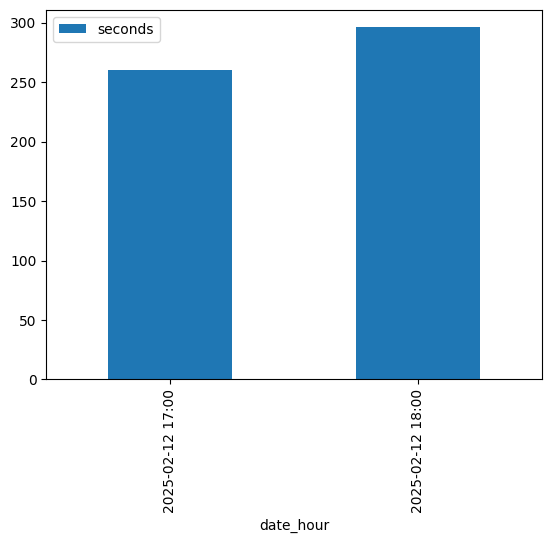

In [48]:
df.plot(kind="bar", x="date_hour", y="seconds")

#### 7.2 Cluster details

In [58]:
SQL_QUERY = f"""
SELECT 
      date
    , hour
    , clusterUuid
    , clusterName
    , seconds_elapsed
FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
ORDER BY 1,2,3
"""
df = bq_client.query(SQL_QUERY).to_dataframe()

In [59]:
df.head()

,date,hour,clusterUuid,clusterName,seconds_elapsed
0,2025-02-12,17,68aac871-dac9-4534-9dba-b3b94adb4925,cluster-f6ef-ktklml7lgv4wa,167
1,2025-02-12,17,89d41015-4d24-4df6-b107-93dc80789a43,cluster-f6ef-ze7qchjeqbgpi,93
2,2025-02-12,18,05804ce3-9436-4ad5-b06e-03ec40136fc7,cluster-f6ef-ftpjdixscxjea,166
3,2025-02-12,18,e78bddb9-ca43-4c1b-96cf-b9427c35f1b8,cluster-f6ef-r4alnh7zqdhtm,130
